CNNs and RNNs on Tensorflow

In [1]:
print('hello and welcome to a functioning script')

hello and welcome to a functioning script


In [2]:
print('running')
import os
import math
import datetime
import IPython
import IPython.display

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf

from sklearn import metrics

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

os.chdir('/rds/general/user/ag1620/home/summerproj/results_data')
os.getcwd()

running


'/rds/general/user/ag1620/home/summerproj/results_data'

In [36]:
dataset_path = "long_expost.csv"
df = pd.read_csv(dataset_path,header=0,index_col=0)

df['chunk'] =  pd.to_datetime(df['chunk'], format="%Y-%m-%d %H:%M:%S")
print(df.columns)
print(df.shape)

trainlength = df[df['traintest'].isin(range(0,1))].shape[0]
testlength = df[df['traintest'].isin(range(1,2))].shape[0]

## Choose your variables!
date_time = df['chunk']
df = df[['texts']]#,'tweet_avg', 'retweet_avg', 'likes_avg',
       #'temp', 'clouds', 'covid_deaths', 'covid_announcements']]

## TRANSFORM YOUR VARIABLES!
df["texts"] = df["texts"].apply(lambda x: math.sqrt(x))
#df["tweet_avg"] = df["tweet_avg"].apply(lambda x: math.log(x+0.1))
#df["retweet_avg"] = df["retweet_avg"].apply(lambda x: math.log(x+0.1))
#df["likes_avg"] = df["likes_avg"].apply(lambda x: math.log(x+0.1))
print("Updated DataFrame:")
df.head()

Index(['chunk', 'texts', 'localtime', 'weekday', 'school_hols',
       'exam_results_week', 'bank_holiday', 'tweets', 'retweets', 'likes',
       'temp', 'clouds', 'rainfall', 'covid_cases', 'covid_deaths',
       'covid_announcements', 'daily_temp', 'tweet_avg', 'retweet_avg',
       'likes_avg', 'traintest'],
      dtype='object')
(10511, 21)
Updated DataFrame:


,texts
1,8.062258
2,7.071068
3,7.071068
4,5.196152
5,4.472136


In [37]:
df.describe()

,texts
count,10511.000000
mean,6.275058
std,2.201831
min,0.000000
25%,4.690416
50%,6.164414
75%,7.681146
max,22.315914


In [38]:
# Creating a new time of day and time of week signal
# time variable is in seconds
day = 24*60*60
week = day*7
year = (365.2425)*day

timestamp_s = date_time.map(pd.Timestamp.timestamp)

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
#df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
#df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
df['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
df['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))

Text(0.5, 1.0, 'Time of day signal')

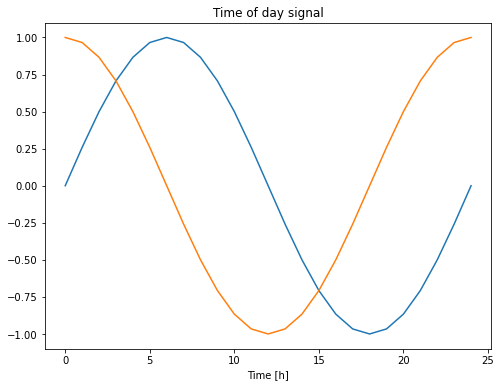

In [39]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [40]:
# Splitting data into 
    # train
    # validation
    # test (already done)

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[:int(trainlength*0.8)]
val_df = df[int(trainlength*0.8):trainlength]
test_df = df[trainlength:]

num_features = df.shape[1]

In [41]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

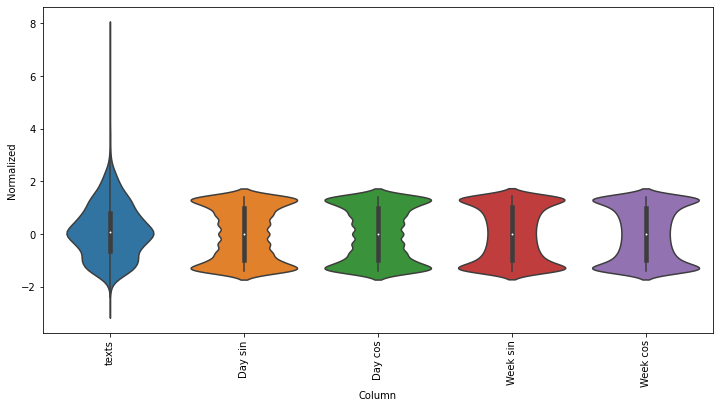

In [42]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Windowing
There are several input window features:
* The width of the input
* The width of the output (prediction/label)
* The time offset (shift) between them
* Which features are used as inputs and labels

The window generator below can create a window of : inputs, labels. 

Then, it can plot the content of these windows.

Finally, it can efficiently generate batches of these windows from the training, validation, and test data.

In [43]:
# Creating a data window

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        def __repr__(self):
            return '\n'.join([
                f'Total window size: {self.total_window_size}',
                f'Input indices: {self.input_indices}',
                f'Label indices: {self.label_indices}',
                f'Label column name(s): {self.label_columns}'])

In [44]:
OUT_STEPS = 24
w1 = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS,
                     label_columns=['texts'])
w1

In [45]:
# Given a list of consecutive inputs this function will convert them to inputs and labels

def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [46]:
# Takes 3 windows, each 48 long (i.e. 48 hrs) and 8 wide (i.e. 8 columns at each timepoint)
# Creates input window of 24 long and 8 wide
# Creates a label output of 1 long and 1 wide

# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 48, 5)
Inputs shape: (3, 24, 5)
labels shape: (3, 24, 1)


In [47]:
# Command which plots the windows

def plot(self, model=None, plot_col='texts', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

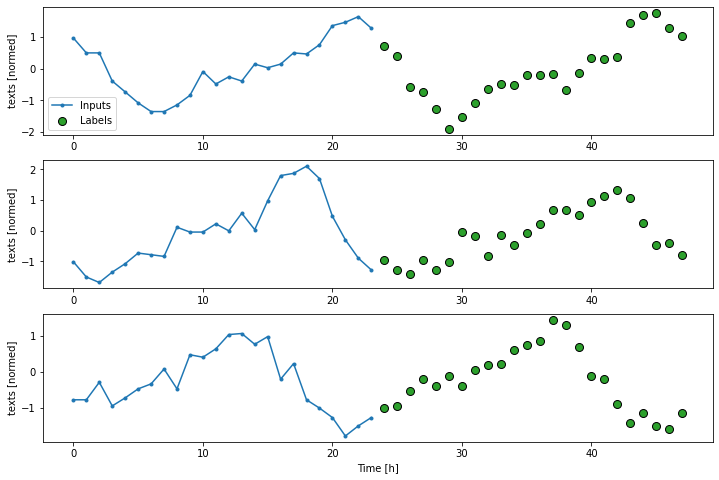

In [48]:
w1.example = example_inputs, example_labels
w1.plot()

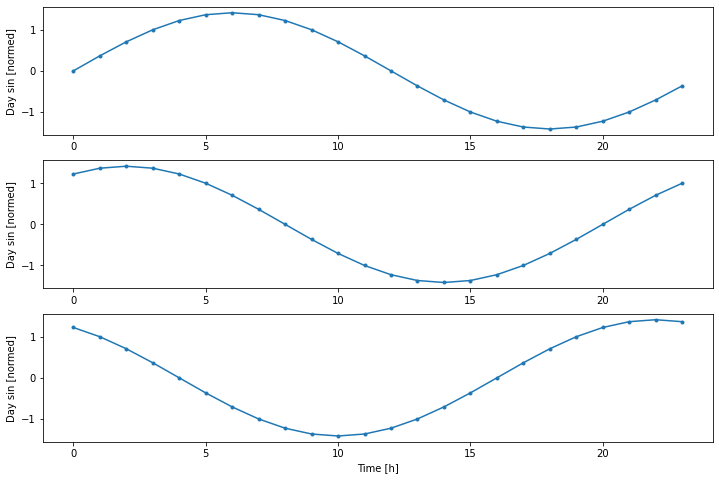

In [49]:
w1.plot(plot_col='Day sin')

In [50]:
# Create a dataset of lots of input-label window pairs

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [53]:
# Each element is an (inputs, label) pair
w1.train.element_spec

(TensorSpec(shape=(None, 24, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))

In [52]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 5)
Labels shape (batch, time, features): (32, 24, 1)


# Training Models

### Test Window Structure

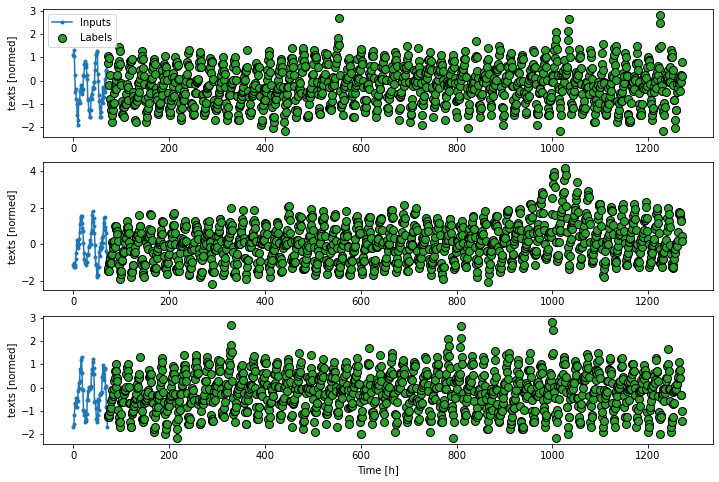

In [54]:
# Here the model predicts 24 hrs into the future, given 24 hrs of the past
INPUT_WINDOW = 3*24
OUT_STEPS = 50*24
multi_window = WindowGenerator(input_width=INPUT_WINDOW,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['texts'])

multi_window.plot()
multi_window

In [55]:
multi_val_performance = {}
multi_performance = {}

MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

## CNN

18/18 [==============================] - 0s 17ms/step - loss: 0.7042 - mean_absolute_error: 0.6807


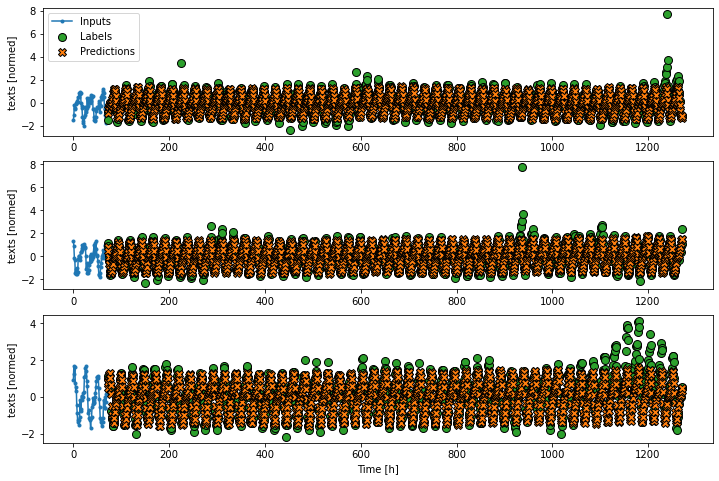

In [22]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

## RNN

18/18 [==============================] - 0s 21ms/step - loss: 0.3573 - mean_absolute_error: 0.4642


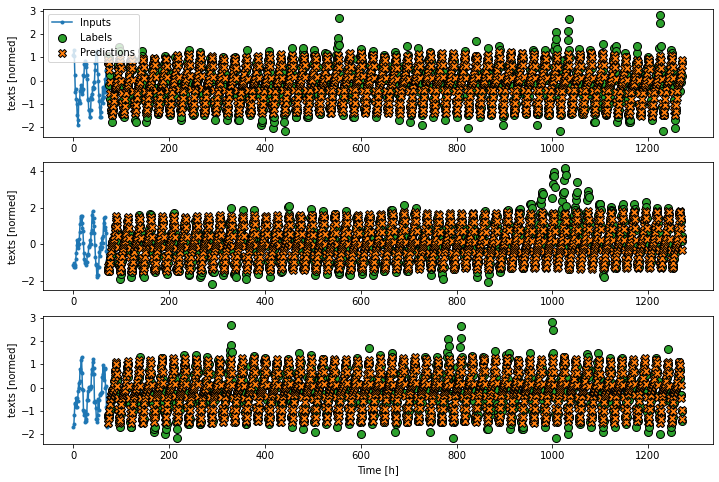

In [56]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Comparison of windowed test sets

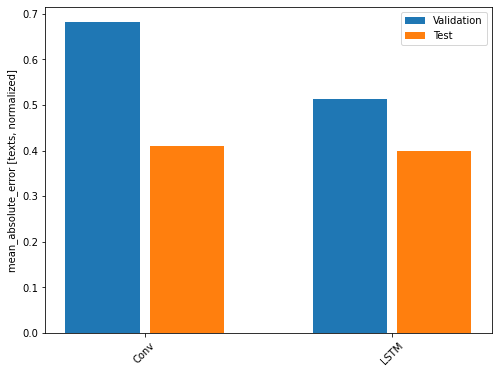

In [24]:
x = np.arange(len(multi_performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.ylabel('mean_absolute_error [texts, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
_ = plt.legend()

# Manual Test Set Prediction
Models:
* multi_linear_model
* multi_dense_model
* multi_conv_model
* multi_lstm_model
* feedback_model

In [25]:
# Final Test Set
column_indices = {name: i for i, name in enumerate(train_df.columns)}
final_test_df = df[(trainlength-INPUT_WINDOW):]
final_test_df = (final_test_df - train_mean) / train_std

Manually select a test window: 
* Take a single window, the length of a multi-window
* Create an array of test_inputs, and an array or test_labels

In [26]:
startime = 0

test_window = tf.stack([np.array(final_test_df[(startime):(startime)+multi_window.total_window_size])    ])

test_inputs, test_labels = multi_window.split_window(test_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {test_window.shape}')
print(f'Inputs shape: {test_inputs.shape}')
print(f'labels shape: {test_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (1, 1272, 12)
Inputs shape: (1, 72, 12)
labels shape: (1, 1200, 1)


In [27]:
truth = (test_labels[0,:,0] * train_std[0] + train_mean[0]) ** 2
preds = (multi_lstm_model.predict(test_inputs)[0,:,0] * train_std[0] + train_mean[0]) **2
truthpred = pd.DataFrame({'truth':truth,'preds':preds})

print(truthpred.head())
print(truthpred.shape)

   truth      preds
0   86.0  50.317928
1   53.0  33.905556
2   32.0  21.183321
3   40.0  14.308185
4   20.0  10.395240
(1200, 2)


Apply a chosen model to create a truth-preds dataframe and plot

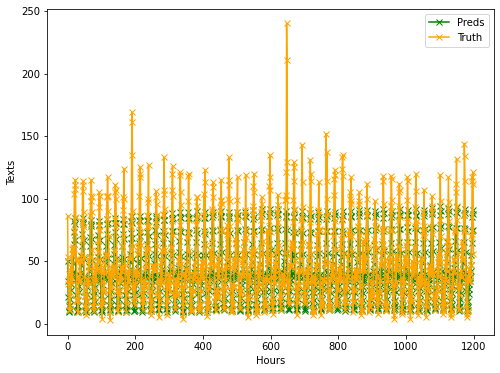

In [28]:
plt.plot(truthpred['preds'],'bx-',color='g',label='Preds')
plt.plot(truthpred['truth'],'bx-',color='orange',label='Truth')
plt.xlabel("Hours")
plt.ylabel("Texts")
plt.legend()

In [29]:
# ASSESS ERROR METRICS
import math
# over what time would you like to assess error metrics?
days = 50
t=truth[:days*24]
p=preds[:days*24]
# Get error metrics
MAE = metrics.mean_absolute_error(t, p)
MSE = metrics.mean_squared_error(t, p)
RMSE = math.sqrt(MSE)
R2 = metrics.r2_score(t, p)
maxerror = metrics.max_error(t, p)
print(' MAE = {}\n MSE = {}\n RMSE = {}\n R2= {}\n max-error = {}'.format(MAE, MSE, RMSE, R2, maxerror))

 MAE = 10.50676169792811
 MSE = 263.33105595198367
 RMSE = 16.227478422477834
 R2= 0.7507796637971919
 max-error = 165.31113433837893


Saving values

In [67]:
# RNN
truth = (test_labels[0,:,0] * train_std[0] + train_mean[0]) ** 2
preds = (multi_lstm_model.predict(test_inputs)[0,:,0] * train_std[0] + train_mean[0]) **2
truthpred = pd.DataFrame({'truth':truth,'preds':preds})

truthpred.head()
#truthpred.to_csv('long_expost_RNN_preds.csv', index=False)
#truthpred.to_csv('long_timeonly_RNN_preds.csv', index=False)

In [42]:
# CNN
truth = (test_labels[0,:,0] * train_std[0] + train_mean[0]) ** 2
preds = (multi_conv_model.predict(test_inputs)[0,:,0] * train_std[0] + train_mean[0]) **2
truthpred = pd.DataFrame({'truth':truth,'preds':preds})

truthpred.head()
#truthpred.to_csv('long_expost_CNN_preds.csv', index=False)

## TRAINING SET PREDICTIONS

In [57]:
# Final TRAINING Test Set
column_indices = {name: i for i, name in enumerate(train_df.columns)}
final_traintest_df = df[(trainlength-INPUT_WINDOW-OUT_STEPS):]
final_traintest_df = (final_traintest_df - train_mean) / train_std

In [58]:
startime = 0

test_window = tf.stack([np.array(final_traintest_df[(startime):(startime)+multi_window.total_window_size])    ])

test_inputs, test_labels = multi_window.split_window(test_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {test_window.shape}')
print(f'Inputs shape: {test_inputs.shape}')
print(f'labels shape: {test_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (1, 1272, 5)
Inputs shape: (1, 72, 5)
labels shape: (1, 1200, 1)


In [59]:
truth = (test_labels[0,:,0] * train_std[0] + train_mean[0]) ** 2
preds = (multi_lstm_model.predict(test_inputs)[0,:,0] * train_std[0] + train_mean[0]) **2
truthpred = pd.DataFrame({'truth':truth,'preds':preds})

print(truthpred.head())
print(truthpred.shape)

   truth      preds
0   94.0  77.139427
1   71.0  57.566242
2   59.0  39.086269
3   38.0  24.537273
4   18.0  14.623533
(1200, 2)


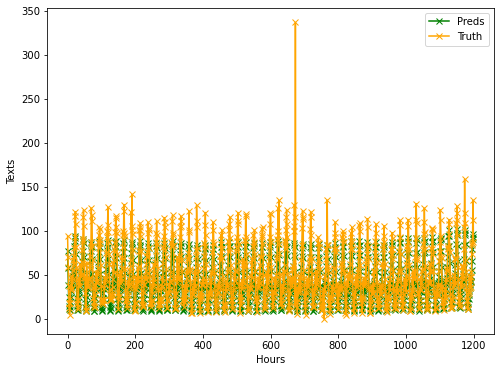

In [60]:
plt.plot(truthpred['preds'],'bx-',color='g',label='Preds')
plt.plot(truthpred['truth'],'bx-',color='orange',label='Truth')
plt.xlabel("Hours")
plt.ylabel("Texts")
plt.legend()

In [61]:
# ASSESS ERROR METRICS
import math
# over what time would you like to assess error metrics?
days = 50
t=truth[:days*24]
p=preds[:days*24]
# Get error metrics
MAE = metrics.mean_absolute_error(t, p)
MSE = metrics.mean_squared_error(t, p)
RMSE = math.sqrt(MSE)
R2 = metrics.r2_score(t, p)
maxerror = metrics.max_error(t, p)
print(' MAE = {}\n MSE = {}\n RMSE = {}\n R2= {}\n max-error = {}'.format(MAE, MSE, RMSE, R2, maxerror))

 MAE = 10.943915520509083
 MSE = 284.8573749594722
 RMSE = 16.877718298380035
 R2= 0.7188042697239896
 max-error = 283.0548515319823


In [62]:
# RNN
truth = (test_labels[0,:,0] * train_std[0] + train_mean[0]) ** 2
preds = (multi_lstm_model.predict(test_inputs)[0,:,0] * train_std[0] + train_mean[0]) **2
truthpred = pd.DataFrame({'truth':truth,'preds':preds})

truthpred.head()
#truthpred.to_csv('long_expost_RNN_train_preds.csv', index=False)
#truthpred.to_csv('long_timeonly_RNN_train_preds.csv', index=False)